# KAYAK Project

## 1. Installing scrapy and Boto3

In [1]:
!pip install scrapy

In [2]:
!pip install Boto3

## 2. Importing librairies

In [75]:
import requests
import pandas as pd
import warnings
import boto3
import plotly.express as px
from bs4 import BeautifulSoup
from dotenv import load_dotenv
load_dotenv()
%reload_ext dotenv
%dotenv
warnings.filterwarnings('ignore')

## 3. Creating Dataframe

In [4]:
df = pd.DataFrame(columns=['city_id' , 'name', 'latitude', 'longitude', 'main_weather', 'risk_of_rain', 'cloudiness', 'day_temperature'])
df

,city_id,name,latitude,longitude,main_weather,risk_of_rain,cloudiness,day_temperature


In [5]:
cities = ["Mont Saint Michel",
"St Malo",
"Bayeux",
"Le Havre",
"Rouen",
"Paris",
"Amiens",
"Lille",
"Strasbourg",
"Chateau du Haut Koenigsbourg",
"Colmar",
"Eguisheim",
"Besancon",
"Dijon",
"Annecy",
"Grenoble",
"Lyon",
"Gorges du Verdon",
"Bormes les Mimosas",
"Cassis",
"Marseille",
"Aix en Provence",
"Avignon",
"Uzes",
"Nimes",
"Aigues Mortes",
"Saintes Maries de la mer",
"Collioure",
"Carcassonne",
"Ariege",
"Toulouse",
"Montauban",
"Biarritz",
"Bayonne",
"La Rochelle"]

In [9]:
cities = pd.Series(cities)
cities = cities.sort_values()
cities = cities.reset_index(drop=True)
cities = cities.to_list()

In [10]:
cities

['Aigues Mortes',
 'Aix en Provence',
 'Amiens',
 'Annecy',
 'Ariege',
 'Avignon',
 'Bayeux',
 'Bayonne',
 'Besancon',
 'Biarritz',
 'Bormes les Mimosas',
 'Carcassonne',
 'Cassis',
 'Chateau du Haut Koenigsbourg',
 'Collioure',
 'Colmar',
 'Dijon',
 'Eguisheim',
 'Gorges du Verdon',
 'Grenoble',
 'La Rochelle',
 'Le Havre',
 'Lille',
 'Lyon',
 'Marseille',
 'Mont Saint Michel',
 'Montauban',
 'Nimes',
 'Paris',
 'Rouen',
 'Saintes Maries de la mer',
 'St Malo',
 'Strasbourg',
 'Toulouse',
 'Uzes']

In [11]:
df['name'] = cities

In [12]:
df['city_id']=df.index

In [13]:
df = df.set_index('city_id')

In [14]:
df

,name,latitude,longitude,main_weather,risk_of_rain,cloudiness,day_temperature
city_id,,,,,,,
0,Aigues Mortes,NaN,NaN,NaN,NaN,NaN,NaN
1,Aix en Provence,NaN,NaN,NaN,NaN,NaN,NaN
2,Amiens,NaN,NaN,NaN,NaN,NaN,NaN
3,Annecy,NaN,NaN,NaN,NaN,NaN,NaN
4,Ariege,NaN,NaN,NaN,NaN,NaN,NaN
5,Avignon,NaN,NaN,NaN,NaN,NaN,NaN
6,Bayeux,NaN,NaN,NaN,NaN,NaN,NaN
7,Bayonne,NaN,NaN,NaN,NaN,NaN,NaN
8,Besancon,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Scrapping hotels

In [15]:
import os
import logging
import ssl
import requests

import scrapy
from scrapy.crawler import CrawlerProcess

class BookingSpider(scrapy.Spider):
    # Name of your spider
    name = "Bookingspider"

    # Starting URL
    start_urls = ['https://www.booking.com/index.fr.html']

    cities = df['name']
    # Parse function for form request
    def parse(self, response):
        # FormRequest used to make a search in each of the 35 cities
        for city in cities :
            yield scrapy.FormRequest.from_response(
                response,
                formdata={'ss': city},
                callback=self.after_search
        )

    # Callback used after login
    def after_search(self, response):

        results = response.xpath('//*[@id="bodyconstraint-inner"]/div[2]/div/div[2]/div[3]/div[2]/div[2]/div[3]')
        location = response.url.split("ss=")[-1].replace('+',' ')

        for r in results:

            yield {

                'city' : location,
                'name': r.css('div.f6431b446c.a15b38c233::text').getall(),
                'url': r.css('h3.aab71f8e4e a::attr(href)').getall(),
                'score' : r.css('div.a3b8729ab1.d86cee9b25::text').getall(),


            }


# Name of the file where the results will be saved
filename = "hotels.json"

# If file already exists, delete it before crawling (because Scrapy will concatenate the last and new results otherwise)
if filename in os.listdir():
        os.remove(filename)

# Declare a new CrawlerProcess with some settings
process = CrawlerProcess(settings = {
    'USER_AGENT': 'Chrome/97.0',
    'LOG_LEVEL': logging.INFO,
    "FEEDS": {
        filename: {"format": "json"},
    }
})

# Start the crawling using the spider you defined above
process.crawl(BookingSpider)
process.start()

2024-03-28 14:57:59 [scrapy.utils.log] INFO: Scrapy 2.8.0 started (bot: scrapybot)
2024-03-28 14:57:59 [scrapy.utils.log] INFO: Versions: lxml 4.9.3.0, libxml2 2.10.4, cssselect 1.1.0, parsel 1.6.0, w3lib 1.21.0, Twisted 22.10.0, Python 3.11.5 (main, Sep 11 2023, 08:19:27) [Clang 14.0.6 ], pyOpenSSL 23.2.0 (OpenSSL 3.0.13 30 Jan 2024), cryptography 41.0.3, Platform macOS-10.16-x86_64-i386-64bit
2024-03-28 14:57:59 [scrapy.crawler] INFO: Overridden settings:
{'LOG_LEVEL': 20, 'USER_AGENT': 'Chrome/97.0'}
2024-03-28 14:57:59 [scrapy.extensions.telnet] INFO: Telnet Password: b283ca521b74c9e5
2024-03-28 14:57:59 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.feedexport.FeedExporter',
 'scrapy.extensions.logstats.LogStats']
2024-03-28 14:57:59 [scrapy.middleware] INFO: Enabled downloader middlewares:
['scrapy.downloadermiddlewares.httpauth.HttpAu

In [16]:
#Creation of dataframe from json file + sort city values + reindex
df_hotels=pd.read_json('hotels.json')
df_hotels = df_hotels.sort_values('city')
df_hotels = df_hotels.reset_index(drop=True)

In [17]:
df_hotels['city_id'] = df_hotels.index #Creation of new column to be used as index
df_hotels = df_hotels.set_index('city_id', drop=True)

In [18]:
df_hotels

,city,name,url,score
city_id,,,,
0,Aigues Mortes,"[La Villa Mazarin, le dit vin secret, Maison d...",[https://www.booking.com/hotel/fr/la-villa-maz...,"[9,2, 8,6, 8,8, 9,1, 8,4, 8,6, 8,2, 9,2, 8,5, ..."
1,Aix en Provence,"[Séjours & Affaires Aix-en-Provence Mirabeau, ...",[https://www.booking.com/hotel/fr/residence-mi...,"[7,8, 8,4, 8,1, 8,6, 7,8, 8,4, 8,0, 8,4, 9,5, ..."
2,Amiens,"[Belaisa*Gare*Centre-Ville, Holiday Inn Expres...",[https://www.booking.com/hotel/fr/belaisa-gare...,"[7,9, 8,5, 8,4, 7,3, 7,4, 7,9, 8,6, 9,3, 9,0, ..."
3,Annecy,"[Allobroges Park Hôtel, Hôtel du Château, Hôte...",[https://www.booking.com/hotel/fr/tiallobroges...,"[8,8, 8,5, 8,5, 8,1, 8,7, 8,9, 8,3, 8,4, 7,7, ..."
4,Ariege,"[Le petit nid, Lagrange Vacances Les Chalets d...",[https://www.booking.com/hotel/fr/le-petit-nid...,"[9,1, 7,8, 8,0, 9,9, 9,5, 9,0, 9,2, 9,0, 9,5, ..."
5,Avignon,"[Logis Hotel Restaurant la Ferme, Au cœur des ...",[https://www.booking.com/hotel/fr/logis-de-fra...,"[8,6, 8,7, 8,3, 7,6, 8,0, 8,0, 8,8, 8,2, 8,3, ..."
6,Bayeux,"[Hotel Reine Mathilde, Hôtel De Brunville & Sp...",[https://www.booking.com/hotel/fr/reine-mathil...,"[8,6, 8,0, 8,1, 8,5, 8,8, 9,2, 8,9, 9,3, 9,1, ..."
7,Bayonne,"[Villa la Renaissance, Hotel Cote Basque, Hôte...",[https://www.booking.com/hotel/fr/villa-la-ren...,"[9,2, 7,9, 9,0, 8,8, 7,5, 8,9, 8,1, 7,7, 9,2, ..."
8,Besancon,"[B&B HOTEL Besançon Valentin, Hôtel de Paris, ...",[https://www.booking.com/hotel/fr/b-amp-b-besa...,"[8,8, 8,2, 7,9, 8,0, 8,3, 8,7, 7,8, 8,5, 7,2, ..."


## 5. Getting cities GPS Coordinates from Nominatim

In [19]:
API_KEY = os.getenv("API_KEY")

In [20]:
#Declaration variables that will contain lat and long coordinates
lat_coord = []
lon_coord = []

for city in cities:

    if city == "Ariege": # Ariege is not a city but a county
        r = requests.get(f"https://nominatim.openstreetmap.org/search?county={city}&country=France&format=json",verify=False).json();
        lat_coord.append(r[0]['lat'])
        lon_coord.append(r[0]['lon'])

    else:
        name_city = city.replace(" ", "%20") #Replacing space to prevent name with "+"
        r = requests.get(f"https://nominatim.openstreetmap.org/search?city={name_city}&country=France&format=json",verify=False).json();
        lat_coord.append(r[0]['lat'])
        lon_coord.append(r[0]['lon'])

# Adding the coordinates to the dataframe
df['latitude'] = lat_coord
df['longitude'] = lon_coord

In [21]:
df.head()

,name,latitude,longitude,main_weather,risk_of_rain,cloudiness,day_temperature
city_id,,,,,,,
0,Aigues Mortes,43.5661521,4.19154,NaN,NaN,NaN,NaN
1,Aix en Provence,43.5298424,5.4474738,NaN,NaN,NaN,NaN
2,Amiens,49.8941708,2.2956951,NaN,NaN,NaN,NaN
3,Annecy,45.8992348,6.1288847,NaN,NaN,NaN,NaN
4,Ariege,42.9455368,1.4065544156065486,NaN,NaN,NaN,NaN


## 6. Requesting openweathermap

In [22]:
for i,row in df.iterrows():
    lat=row['latitude']
    lon=row['longitude']
    print("Request for {} :".format(cities[i]))
    r = requests.get(f"https://api.openweathermap.org/data/2.5/onecall?lat={lat}&lon={lon}&exclude=current,minutely,hourly&units=metric&appid={API_KEY}",
                     verify=False).json()
    print(r)
    # Extract cloudiness
    cloudiness = pd.Series([d['clouds'] for d in r['daily'][1:]]) #First item is the current weather. We want weather for next 7 days hence [1:]
    mean_cloudiness = cloudiness.mean()

    #Extract temperature
    temperature = pd.Series([d['temp']['day'] for d in r['daily'][1:]]) #First item is the current weather. We want weather for next 7 days hence [1:]
    mean_temperature = temperature.mean()

    #Extract main weather
    weather = pd.Series([d['weather'][0]['main'] for d in r['daily'][1:]]) #First item is the current weather. We want weather for next 7 days hence [1:]
    main_weather = weather.mode()[0]

    #Extract % probability of rain
    rain_prob = pd.Series([d['pop']*100 for d in r['daily'][1:]]) #First item is the current weather. We want weather for next 7 days hence [1:]
    mean_rain_prob = rain_prob.mean()

    #Extract Wind gust
    wind = pd.Series([d['wind_gust'] for d in r['daily'][1:]]) #First item is the current weather. We want weather for next 7 days hence [1:]
    max_wind = wind.max()


    df.loc[i, 'cloudiness'] = mean_cloudiness
    df.loc[i, 'day_temperature'] = mean_temperature
    df.loc[i, 'main_weather'] = main_weather
    df.loc[i, 'risk_of_rain'] = mean_rain_prob
    df.loc[i, 'wind_gust_max'] = max_wind

Request for Aigues Mortes :
{'lat': 43.5662, 'lon': 4.1915, 'timezone': 'Europe/Paris', 'timezone_offset': 3600, 'daily': [{'dt': 1711623600, 'sunrise': 1711603888, 'sunset': 1711649082, 'moonrise': 1711661940, 'moonset': 1711608000, 'moon_phase': 0.6, 'temp': {'day': 13.5, 'min': 10.76, 'max': 14.92, 'night': 14.52, 'eve': 13.9, 'morn': 12.37}, 'feels_like': {'day': 12.52, 'night': 14.19, 'eve': 13.33, 'morn': 11.54}, 'pressure': 1003, 'humidity': 62, 'dew_point': 6.37, 'wind_speed': 9.97, 'wind_deg': 151, 'wind_gust': 15.96, 'weather': [{'id': 500, 'main': 'Rain', 'description': 'light rain', 'icon': '10d'}], 'clouds': 51, 'pop': 0.2, 'rain': 0.12, 'uvi': 4.03}, {'dt': 1711710000, 'sunrise': 1711690179, 'sunset': 1711735553, 'moonrise': 1711752480, 'moonset': 1711695900, 'moon_phase': 0.63, 'temp': {'day': 15.5, 'min': 14.46, 'max': 16.04, 'night': 15.02, 'eve': 14.89, 'morn': 14.72}, 'feels_like': {'day': 15.17, 'night': 14.59, 'eve': 14.58, 'morn': 14.47}, 'pressure': 1002, 'humidi

In [23]:
df

,name,latitude,longitude,main_weather,risk_of_rain,cloudiness,day_temperature,wind_gust_max
city_id,,,,,,,,
0,Aigues Mortes,43.5661521,4.19154,Rain,41.142857,72.714286,15.35,22.46
1,Aix en Provence,43.5298424,5.4474738,Rain,57.142857,71.142857,15.888571,18.11
2,Amiens,49.8941708,2.2956951,Rain,85.714286,94.142857,11.555714,15.77
3,Annecy,45.8992348,6.1288847,Rain,85.714286,90.285714,12.534286,11.95
4,Ariege,42.9455368,1.4065544156065486,Rain,100.0,54.0,11.83,9.04
5,Avignon,43.9492493,4.8059012,Rain,60.714286,74.571429,16.982857,20.95
6,Bayeux,49.2764624,-0.7024738,Rain,99.142857,80.428571,12.78,15.84
7,Bayonne,43.4945144,-1.4736657,Rain,67.714286,88.142857,15.8,18.82
8,Besancon,47.2380222,6.0243622,Rain,99.285714,91.285714,12.214286,23.72


## 7. Scrapping hotels coordinates, description and rating

In [24]:
# Initializing the scraper with BeautifulSoup
latitude_all = []
longitude_all = []
description_all = []
rating_all = []

for i in range(len(df_hotels["url"])):
    latitude_list = []
    longitude_list = []
    description_list = []
    rating_list = []
    hotel_url_list = df_hotels["url"][i]
    print ("Computing {}/35 : {}...".format(i+1,df_hotels['city'][i]))

    for url in hotel_url_list:

        page = requests.get(url,verify=False)
        soup = BeautifulSoup(page.text, 'html.parser')

        #Adding lat, lon and descriptions to the respective lists
        latitude_list.append(soup.select('a#hotel_address')[0].get("data-atlas-latlng").split(",")[0])
        longitude_list.append(soup.select('a#hotel_address')[0].get("data-atlas-latlng").split(",")[1])
        description_list.append(soup.select('p.a53cbfa6de.b3efd73f69')[0].get_text())

        #Adding rating (if is available) to rating_list
        try:
            rating_list.append(soup.select('div.a3b8729ab1.d86cee9b25')[0].get_text())
            
        # If the rating is missing, let's set a default value of 5.0
        except:
            rating_list.append("5.0")


    latitude_all.append(latitude_list)
    longitude_all.append(longitude_list)
    description_all.append(description_list)
    rating_all.append(rating_list)

    # Printing the progress (very long ~ 45 min)
    print ("Done")

# Adding new columns based on lists of lists gathered above
df_hotels["hotel_lat"] = latitude_all
df_hotels["hotel_long"] = longitude_all
df_hotels["description"] = description_all
df_hotels["Rating"] = rating_all
print('The process is successfully completed')

Computing 1/35 : Aigues Mortes...
Done
Computing 2/35 : Aix en Provence...
Done
Computing 3/35 : Amiens...
Done
Computing 4/35 : Annecy...
Done
Computing 5/35 : Ariege...
Done
Computing 6/35 : Avignon...
Done
Computing 7/35 : Bayeux...
Done
Computing 8/35 : Bayonne...
Done
Computing 9/35 : Besancon...
Done
Computing 10/35 : Biarritz...
Done
Computing 11/35 : Bormes les Mimosas...
Done
Computing 12/35 : Carcassonne...
Done
Computing 13/35 : Cassis...
Done
Computing 14/35 : Chateau du Haut Koenigsbourg...
Done
Computing 15/35 : Collioure...
Done
Computing 16/35 : Colmar...
Done
Computing 17/35 : Dijon...
Done
Computing 18/35 : Eguisheim...
Done
Computing 19/35 : Gorges du Verdon...
Done
Computing 20/35 : Grenoble...
Done
Computing 21/35 : La Rochelle...
Done
Computing 22/35 : Le Havre...
Done
Computing 23/35 : Lille...
Done
Computing 24/35 : Lyon...
Done
Computing 25/35 : Marseille...
Done
Computing 26/35 : Mont Saint Michel...
Done
Computing 27/35 : Montauban...
Done
Computing 28/35 : N

In [25]:
df_hotels.head()

,city,name,url,score,hotel_lat,hotel_long,description,Rating
city_id,,,,,,,,
0,Aigues Mortes,"[La Villa Mazarin, le dit vin secret, Maison d...",[https://www.booking.com/hotel/fr/la-villa-maz...,"[9,2, 8,6, 8,8, 9,1, 8,4, 8,6, 8,2, 9,2, 8,5, ...","[43.56498662, 43.56676900, 43.56899740, 43.566...","[4.19175196, 4.18911300, 4.18829820, 4.1923532...",[La Villa Mazarin est construite dans un bâtim...,"[9,2Avec une note de 9.2, 8,6Avec une note de ..."
1,Aix en Provence,"[Séjours & Affaires Aix-en-Provence Mirabeau, ...",[https://www.booking.com/hotel/fr/residence-mi...,"[7,8, 8,4, 8,1, 8,6, 7,8, 8,4, 8,0, 8,4, 9,5, ...","[43.52524078, 43.52624048, 43.52688664, 43.531...","[5.44126600, 5.43820493, 5.44727147, 5.4450700...",[Cette résidence Séjours & Affaires est située...,"[7,8Avec une note de 7.8, 8,4Avec une note de ..."
2,Amiens,"[Belaisa*Gare*Centre-Ville, Holiday Inn Expres...",[https://www.booking.com/hotel/fr/belaisa-gare...,"[7,9, 8,5, 8,4, 7,3, 7,4, 7,9, 8,6, 9,3, 9,0, ...","[49.89366800, 49.89167620, 49.89124900, 49.894...","[2.31141800, 2.30775386, 2.30953000, 2.3009423...","[Situé à 600 mètres de la gare d'Amiens, à 3,9...","[8.88.8, 7,9Avec une note de 7.9, 8,5Avec une ..."
3,Annecy,"[Allobroges Park Hôtel, Hôtel du Château, Hôte...",[https://www.booking.com/hotel/fr/tiallobroges...,"[8,8, 8,5, 8,5, 8,1, 8,7, 8,9, 8,3, 8,4, 7,7, ...","[45.90218661, 45.89789347, 45.90163038, 45.880...","[6.12380505, 6.12520516, 6.12292528, 6.0971304...",[L'établissement 3 étoiles Allobroges Park Hôt...,"[8,8Avec une note de 8.8, 8,5Avec une note de ..."
4,Ariege,"[Le petit nid, Lagrange Vacances Les Chalets d...",[https://www.booking.com/hotel/fr/le-petit-nid...,"[9,1, 7,8, 8,0, 9,9, 9,5, 9,0, 9,2, 9,0, 9,5, ...","[42.93227802, 42.71383156, 43.00523950, 42.935...","[1.63516787, 1.83920681, 1.61475956, 1.5731692...","[Situé à Montgaillard, l'appartement Le petit ...","[9,1Avec une note de 9.1, 7,8Avec une note de ..."


## 8. Cleaning and merging dataframes

In [26]:
df_hotels = df_hotels.drop(['score'], axis=1) # Dropping the score column which is redundant with Rating column

In [41]:
colum_to_explode = df_hotels.columns[1:].tolist() #List of column to explode

In [42]:
df_hotels_clean = df_hotels.explode(colum_to_explode) #Exploding desired columns

In [43]:
df_hotels_clean['Rating'] = df_hotels_clean['Rating'].apply(lambda x: x[:3]) # Keeping only the first 3 characters (ie the rating)

In [44]:
df_hotels_clean.index.name ='city_id'

In [45]:
df_total = pd.merge(df, df_hotels_clean, on='city_id') # Merging both dataframes
df_total.rename(columns={'name_y':'hotel_name'},inplace=True)
df_total.drop(['city'], axis=1, inplace=True)
df_total.rename(columns={'name_x':'City'},inplace=True)
df_total.head()

,City,latitude,longitude,main_weather,risk_of_rain,cloudiness,day_temperature,wind_gust_max,hotel_name,url,hotel_lat,hotel_long,description,Rating
city_id,,,,,,,,,,,,,,
0,Aigues Mortes,43.5661521,4.19154,Rain,41.142857,72.714286,15.35,22.46,La Villa Mazarin,https://www.booking.com/hotel/fr/la-villa-maza...,43.56498662,4.19175196,La Villa Mazarin est construite dans un bâtime...,"9,2"
0,Aigues Mortes,43.5661521,4.19154,Rain,41.142857,72.714286,15.35,22.46,le dit vin secret,https://www.booking.com/hotel/fr/le-dit-vin-se...,43.56676900,4.18911300,"Situé à Aigues-Mortes, à 24 km de la salle omn...","8,6"
0,Aigues Mortes,43.5661521,4.19154,Rain,41.142857,72.714286,15.35,22.46,Maison des Croisades,https://www.booking.com/hotel/fr/des-croisades...,43.56899740,4.18829820,"Située à Aigues-Mortes, la Maison des Croisade...","8,8"
0,Aigues Mortes,43.5661521,4.19154,Rain,41.142857,72.714286,15.35,22.46,La Maison de Lyna,https://www.booking.com/hotel/fr/la-maison-de-...,43.56601750,4.19235320,"Situé à Aigues-Mortes, à 24 km de la salle omn...","9,1"
0,Aigues Mortes,43.5661521,4.19154,Rain,41.142857,72.714286,15.35,22.46,Hôtel Saint Louis,https://www.booking.com/hotel/fr/saint-louis-a...,43.56721967,4.18934360,"Situé dans le cœur historique d'Aigues-Mortes,...","8,4"


In [46]:
#Converting df in .csv
df_total.to_csv('df_total.csv')

## 9. Store the csv in S3

In [47]:
# Read the S3 credentials
ACCESS_KEY_ID = os.getenv("ACCESS_KEY_ID")
SECRET_ACCESS_KEY = os.getenv("SECRET_ACCESS_KEY")

In [48]:
# Establishing the session using the actual access keys
session = boto3.Session(
    aws_access_key_id=ACCESS_KEY_ID,
    aws_secret_access_key=SECRET_ACCESS_KEY
)

In [49]:
# Loading the S3 session and resource
s3 = session.resource('s3')

In [50]:
# Uploading the file to S3
bucket_name = 'kayak-final-project'
s3.create_bucket(Bucket=bucket_name)
s3.Bucket(bucket_name).upload_file('df_total.csv', 'df_total.csv')

In [ ]:
!pip install psycopg2-binary

## 10. RDS

In [51]:
# RDS Connection
HOSTNAME = os.getenv("HOSTNAME")
USERNAME = os.getenv("USERNAME")
PASSWORD = os.getenv("PASSWORD")
DBNAME = os.getenv("DBNAME")
PORT = os.getenv("PORT")

In [52]:
# Importing libraries for the data warehousing and initialization of the SQL engine
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker

engine = create_engine(f"postgresql+psycopg2://{USERNAME}:{PASSWORD}@{HOSTNAME}/{DBNAME}", echo=True)
Session = sessionmaker(bind=engine)
session = Session()

In [53]:
conn=engine.connect()

2024-03-28 15:34:29,919 INFO sqlalchemy.engine.Engine select pg_catalog.version()


2024-03-28 15:34:29 [sqlalchemy.engine.Engine] INFO: select pg_catalog.version()


2024-03-28 15:34:29,920 INFO sqlalchemy.engine.Engine [raw sql] {}


2024-03-28 15:34:29 [sqlalchemy.engine.Engine] INFO: [raw sql] {}


2024-03-28 15:34:30,276 INFO sqlalchemy.engine.Engine select current_schema()


2024-03-28 15:34:30 [sqlalchemy.engine.Engine] INFO: select current_schema()


2024-03-28 15:34:30,277 INFO sqlalchemy.engine.Engine [raw sql] {}


2024-03-28 15:34:30 [sqlalchemy.engine.Engine] INFO: [raw sql] {}


2024-03-28 15:34:30,504 INFO sqlalchemy.engine.Engine show standard_conforming_strings


2024-03-28 15:34:30 [sqlalchemy.engine.Engine] INFO: show standard_conforming_strings


2024-03-28 15:34:30,506 INFO sqlalchemy.engine.Engine [raw sql] {}


2024-03-28 15:34:30 [sqlalchemy.engine.Engine] INFO: [raw sql] {}


In [54]:
df_total.to_sql('df_total', con=engine, if_exists='replace', index=False)

2024-03-28 15:34:34,509 INFO sqlalchemy.engine.Engine BEGIN (implicit)


2024-03-28 15:34:34 [sqlalchemy.engine.Engine] INFO: BEGIN (implicit)


2024-03-28 15:34:34,517 INFO sqlalchemy.engine.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s


2024-03-28 15:34:34 [sqlalchemy.engine.Engine] INFO: select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s


2024-03-28 15:34:34,519 INFO sqlalchemy.engine.Engine [generated in 0.00238s] {'name': 'df_total'}


2024-03-28 15:34:34 [sqlalchemy.engine.Engine] INFO: [generated in 0.00238s] {'name': 'df_total'}


2024-03-28 15:34:34,790 INFO sqlalchemy.engine.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s


2024-03-28 15:34:34 [sqlalchemy.engine.Engine] INFO: select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s


2024-03-28 15:34:34,791 INFO sqlalchemy.engine.Engine [cached since 0.2743s ago] {'name': 'df_total'}


2024-03-28 15:34:34 [sqlalchemy.engine.Engine] INFO: [cached since 0.2743s ago] {'name': 'df_total'}


2024-03-28 15:34:34,900 INFO sqlalchemy.engine.Engine SELECT c.relname FROM pg_class c JOIN pg_namespace n ON n.oid = c.relnamespace WHERE n.nspname = %(schema)s AND c.relkind in ('r', 'p')


2024-03-28 15:34:34 [sqlalchemy.engine.Engine] INFO: SELECT c.relname FROM pg_class c JOIN pg_namespace n ON n.oid = c.relnamespace WHERE n.nspname = %(schema)s AND c.relkind in ('r', 'p')


2024-03-28 15:34:34,902 INFO sqlalchemy.engine.Engine [generated in 0.00165s] {'schema': 'public'}


2024-03-28 15:34:34 [sqlalchemy.engine.Engine] INFO: [generated in 0.00165s] {'schema': 'public'}


2024-03-28 15:34:35,335 INFO sqlalchemy.engine.Engine 
            SELECT c.oid
            FROM pg_catalog.pg_class c
            LEFT JOIN pg_catalog.pg_namespace n ON n.oid = c.relnamespace
            WHERE (pg_catalog.pg_table_is_visible(c.oid))
            AND c.relname = %(table_name)s AND c.relkind in
            ('r', 'v', 'm', 'f', 'p')
        


2024-03-28 15:34:35 [sqlalchemy.engine.Engine] INFO: 
            SELECT c.oid
            FROM pg_catalog.pg_class c
            LEFT JOIN pg_catalog.pg_namespace n ON n.oid = c.relnamespace
            WHERE (pg_catalog.pg_table_is_visible(c.oid))
            AND c.relname = %(table_name)s AND c.relkind in
            ('r', 'v', 'm', 'f', 'p')
        


2024-03-28 15:34:35,336 INFO sqlalchemy.engine.Engine [generated in 0.00181s] {'table_name': 'df_total'}


2024-03-28 15:34:35 [sqlalchemy.engine.Engine] INFO: [generated in 0.00181s] {'table_name': 'df_total'}


2024-03-28 15:34:35,546 INFO sqlalchemy.engine.Engine 
            SELECT a.attname,
              pg_catalog.format_type(a.atttypid, a.atttypmod),
              (
                SELECT pg_catalog.pg_get_expr(d.adbin, d.adrelid)
                FROM pg_catalog.pg_attrdef d
                WHERE d.adrelid = a.attrelid AND d.adnum = a.attnum
                AND a.atthasdef
              ) AS DEFAULT,
              a.attnotnull,
              a.attrelid as table_oid,
              pgd.description as comment,
              a.attgenerated as generated,
                              (SELECT json_build_object(
                    'always', a.attidentity = 'a',
                    'start', s.seqstart,
                    'increment', s.seqincrement,
                    'minvalue', s.seqmin,
                    'maxvalue', s.seqmax,
                    'cache', s.seqcache,
                    'cycle', s.seqcycle)
                FROM pg_catalog.pg_sequence s
                JOIN pg_catalog.pg_

2024-03-28 15:34:35 [sqlalchemy.engine.Engine] INFO: 
            SELECT a.attname,
              pg_catalog.format_type(a.atttypid, a.atttypmod),
              (
                SELECT pg_catalog.pg_get_expr(d.adbin, d.adrelid)
                FROM pg_catalog.pg_attrdef d
                WHERE d.adrelid = a.attrelid AND d.adnum = a.attnum
                AND a.atthasdef
              ) AS DEFAULT,
              a.attnotnull,
              a.attrelid as table_oid,
              pgd.description as comment,
              a.attgenerated as generated,
                              (SELECT json_build_object(
                    'always', a.attidentity = 'a',
                    'start', s.seqstart,
                    'increment', s.seqincrement,
                    'minvalue', s.seqmin,
                    'maxvalue', s.seqmax,
                    'cache', s.seqcache,
                    'cycle', s.seqcycle)
                FROM pg_catalog.pg_sequence s
                JOIN pg_catalog.pg_c

2024-03-28 15:34:35,547 INFO sqlalchemy.engine.Engine [generated in 0.00166s] {'table_oid': 16446}


2024-03-28 15:34:35 [sqlalchemy.engine.Engine] INFO: [generated in 0.00166s] {'table_oid': 16446}


2024-03-28 15:34:35,717 INFO sqlalchemy.engine.Engine 
            SELECT t.typname as "name",
               pg_catalog.format_type(t.typbasetype, t.typtypmod) as "attype",
               not t.typnotnull as "nullable",
               t.typdefault as "default",
               pg_catalog.pg_type_is_visible(t.oid) as "visible",
               n.nspname as "schema"
            FROM pg_catalog.pg_type t
               LEFT JOIN pg_catalog.pg_namespace n ON n.oid = t.typnamespace
            WHERE t.typtype = 'd'
        


2024-03-28 15:34:35 [sqlalchemy.engine.Engine] INFO: 
            SELECT t.typname as "name",
               pg_catalog.format_type(t.typbasetype, t.typtypmod) as "attype",
               not t.typnotnull as "nullable",
               t.typdefault as "default",
               pg_catalog.pg_type_is_visible(t.oid) as "visible",
               n.nspname as "schema"
            FROM pg_catalog.pg_type t
               LEFT JOIN pg_catalog.pg_namespace n ON n.oid = t.typnamespace
            WHERE t.typtype = 'd'
        


2024-03-28 15:34:35,718 INFO sqlalchemy.engine.Engine [generated in 0.00136s] {}


2024-03-28 15:34:35 [sqlalchemy.engine.Engine] INFO: [generated in 0.00136s] {}


2024-03-28 15:34:35,926 INFO sqlalchemy.engine.Engine 
            SELECT t.typname as "name",
               -- no enum defaults in 8.4 at least
               -- t.typdefault as "default",
               pg_catalog.pg_type_is_visible(t.oid) as "visible",
               n.nspname as "schema",
               e.enumlabel as "label"
            FROM pg_catalog.pg_type t
                 LEFT JOIN pg_catalog.pg_namespace n ON n.oid = t.typnamespace
                 LEFT JOIN pg_catalog.pg_enum e ON t.oid = e.enumtypid
            WHERE t.typtype = 'e'
        ORDER BY "schema", "name", e.oid


2024-03-28 15:34:35 [sqlalchemy.engine.Engine] INFO: 
            SELECT t.typname as "name",
               -- no enum defaults in 8.4 at least
               -- t.typdefault as "default",
               pg_catalog.pg_type_is_visible(t.oid) as "visible",
               n.nspname as "schema",
               e.enumlabel as "label"
            FROM pg_catalog.pg_type t
                 LEFT JOIN pg_catalog.pg_namespace n ON n.oid = t.typnamespace
                 LEFT JOIN pg_catalog.pg_enum e ON t.oid = e.enumtypid
            WHERE t.typtype = 'e'
        ORDER BY "schema", "name", e.oid


2024-03-28 15:34:35,928 INFO sqlalchemy.engine.Engine [generated in 0.00267s] {}


2024-03-28 15:34:35 [sqlalchemy.engine.Engine] INFO: [generated in 0.00267s] {}


2024-03-28 15:34:36,046 INFO sqlalchemy.engine.Engine 
                SELECT a.attname
                FROM pg_attribute a JOIN (
                    SELECT unnest(ix.indkey) attnum,
                           generate_subscripts(ix.indkey, 1) ord
                    FROM pg_index ix
                    WHERE ix.indrelid = %(table_oid)s AND ix.indisprimary
                    ) k ON a.attnum=k.attnum
                WHERE a.attrelid = %(table_oid)s
                ORDER BY k.ord
            


2024-03-28 15:34:36 [sqlalchemy.engine.Engine] INFO: 
                SELECT a.attname
                FROM pg_attribute a JOIN (
                    SELECT unnest(ix.indkey) attnum,
                           generate_subscripts(ix.indkey, 1) ord
                    FROM pg_index ix
                    WHERE ix.indrelid = %(table_oid)s AND ix.indisprimary
                    ) k ON a.attnum=k.attnum
                WHERE a.attrelid = %(table_oid)s
                ORDER BY k.ord
            


2024-03-28 15:34:36,047 INFO sqlalchemy.engine.Engine [generated in 0.00132s] {'table_oid': 16446}


2024-03-28 15:34:36 [sqlalchemy.engine.Engine] INFO: [generated in 0.00132s] {'table_oid': 16446}


2024-03-28 15:34:36,225 INFO sqlalchemy.engine.Engine 
        SELECT conname
           FROM  pg_catalog.pg_constraint r
           WHERE r.conrelid = %(table_oid)s AND r.contype = 'p'
           ORDER BY 1
        


2024-03-28 15:34:36 [sqlalchemy.engine.Engine] INFO: 
        SELECT conname
           FROM  pg_catalog.pg_constraint r
           WHERE r.conrelid = %(table_oid)s AND r.contype = 'p'
           ORDER BY 1
        


2024-03-28 15:34:36,230 INFO sqlalchemy.engine.Engine [generated in 0.00513s] {'table_oid': 16446}


2024-03-28 15:34:36 [sqlalchemy.engine.Engine] INFO: [generated in 0.00513s] {'table_oid': 16446}


2024-03-28 15:34:36,350 INFO sqlalchemy.engine.Engine 
          SELECT r.conname,
                pg_catalog.pg_get_constraintdef(r.oid, true) as condef,
                n.nspname as conschema
          FROM  pg_catalog.pg_constraint r,
                pg_namespace n,
                pg_class c

          WHERE r.conrelid = %(table)s AND
                r.contype = 'f' AND
                c.oid = confrelid AND
                n.oid = c.relnamespace
          ORDER BY 1
        


2024-03-28 15:34:36 [sqlalchemy.engine.Engine] INFO: 
          SELECT r.conname,
                pg_catalog.pg_get_constraintdef(r.oid, true) as condef,
                n.nspname as conschema
          FROM  pg_catalog.pg_constraint r,
                pg_namespace n,
                pg_class c

          WHERE r.conrelid = %(table)s AND
                r.contype = 'f' AND
                c.oid = confrelid AND
                n.oid = c.relnamespace
          ORDER BY 1
        


2024-03-28 15:34:36,351 INFO sqlalchemy.engine.Engine [generated in 0.00150s] {'table': 16446}


2024-03-28 15:34:36 [sqlalchemy.engine.Engine] INFO: [generated in 0.00150s] {'table': 16446}


2024-03-28 15:34:36,539 INFO sqlalchemy.engine.Engine 
              SELECT
                  i.relname as relname,
                  ix.indisunique, ix.indexprs,
                  a.attname, a.attnum, c.conrelid, ix.indkey::varchar,
                  ix.indoption::varchar, i.reloptions, am.amname,
                  pg_get_expr(ix.indpred, ix.indrelid),
                  ix.indnkeyatts as indnkeyatts
              FROM
                  pg_class t
                        join pg_index ix on t.oid = ix.indrelid
                        join pg_class i on i.oid = ix.indexrelid
                        left outer join
                            pg_attribute a
                            on t.oid = a.attrelid and a.attnum = ANY(ix.indkey)
                        left outer join
                            pg_constraint c
                            on (ix.indrelid = c.conrelid and
                                ix.indexrelid = c.conindid and
                                c.contype in ('p

2024-03-28 15:34:36 [sqlalchemy.engine.Engine] INFO: 
              SELECT
                  i.relname as relname,
                  ix.indisunique, ix.indexprs,
                  a.attname, a.attnum, c.conrelid, ix.indkey::varchar,
                  ix.indoption::varchar, i.reloptions, am.amname,
                  pg_get_expr(ix.indpred, ix.indrelid),
                  ix.indnkeyatts as indnkeyatts
              FROM
                  pg_class t
                        join pg_index ix on t.oid = ix.indrelid
                        join pg_class i on i.oid = ix.indexrelid
                        left outer join
                            pg_attribute a
                            on t.oid = a.attrelid and a.attnum = ANY(ix.indkey)
                        left outer join
                            pg_constraint c
                            on (ix.indrelid = c.conrelid and
                                ix.indexrelid = c.conindid and
                                c.contype in ('p'

2024-03-28 15:34:36,541 INFO sqlalchemy.engine.Engine [generated in 0.00190s] {'table_oid': 16446}


2024-03-28 15:34:36 [sqlalchemy.engine.Engine] INFO: [generated in 0.00190s] {'table_oid': 16446}


2024-03-28 15:34:36,655 INFO sqlalchemy.engine.Engine 
            SELECT
                cons.conname as name,
                cons.conkey as key,
                a.attnum as col_num,
                a.attname as col_name
            FROM
                pg_catalog.pg_constraint cons
                join pg_attribute a
                  on cons.conrelid = a.attrelid AND
                    a.attnum = ANY(cons.conkey)
            WHERE
                cons.conrelid = %(table_oid)s AND
                cons.contype = 'u'
        


2024-03-28 15:34:36 [sqlalchemy.engine.Engine] INFO: 
            SELECT
                cons.conname as name,
                cons.conkey as key,
                a.attnum as col_num,
                a.attname as col_name
            FROM
                pg_catalog.pg_constraint cons
                join pg_attribute a
                  on cons.conrelid = a.attrelid AND
                    a.attnum = ANY(cons.conkey)
            WHERE
                cons.conrelid = %(table_oid)s AND
                cons.contype = 'u'
        


2024-03-28 15:34:36,657 INFO sqlalchemy.engine.Engine [generated in 0.00180s] {'table_oid': 16446}


2024-03-28 15:34:36 [sqlalchemy.engine.Engine] INFO: [generated in 0.00180s] {'table_oid': 16446}


2024-03-28 15:34:36,771 INFO sqlalchemy.engine.Engine 
            SELECT
                cons.conname as name,
                pg_get_constraintdef(cons.oid) as src
            FROM
                pg_catalog.pg_constraint cons
            WHERE
                cons.conrelid = %(table_oid)s AND
                cons.contype = 'c'
        


2024-03-28 15:34:36 [sqlalchemy.engine.Engine] INFO: 
            SELECT
                cons.conname as name,
                pg_get_constraintdef(cons.oid) as src
            FROM
                pg_catalog.pg_constraint cons
            WHERE
                cons.conrelid = %(table_oid)s AND
                cons.contype = 'c'
        


2024-03-28 15:34:36,773 INFO sqlalchemy.engine.Engine [generated in 0.00185s] {'table_oid': 16446}


2024-03-28 15:34:36 [sqlalchemy.engine.Engine] INFO: [generated in 0.00185s] {'table_oid': 16446}


2024-03-28 15:34:37,049 INFO sqlalchemy.engine.Engine 
            SELECT
                pgd.description as table_comment
            FROM
                pg_catalog.pg_description pgd
            WHERE
                pgd.objsubid = 0 AND
                pgd.objoid = %(table_oid)s
        


2024-03-28 15:34:37 [sqlalchemy.engine.Engine] INFO: 
            SELECT
                pgd.description as table_comment
            FROM
                pg_catalog.pg_description pgd
            WHERE
                pgd.objsubid = 0 AND
                pgd.objoid = %(table_oid)s
        


2024-03-28 15:34:37,050 INFO sqlalchemy.engine.Engine [generated in 0.00155s] {'table_oid': 16446}


2024-03-28 15:34:37 [sqlalchemy.engine.Engine] INFO: [generated in 0.00155s] {'table_oid': 16446}


2024-03-28 15:34:37,349 INFO sqlalchemy.engine.Engine 
DROP TABLE df_total


2024-03-28 15:34:37 [sqlalchemy.engine.Engine] INFO: 
DROP TABLE df_total


2024-03-28 15:34:37,351 INFO sqlalchemy.engine.Engine [no key 0.00138s] {}


2024-03-28 15:34:37 [sqlalchemy.engine.Engine] INFO: [no key 0.00138s] {}


2024-03-28 15:34:37,470 INFO sqlalchemy.engine.Engine 
CREATE TABLE df_total (
	"City" TEXT, 
	latitude TEXT, 
	longitude TEXT, 
	main_weather TEXT, 
	risk_of_rain FLOAT(53), 
	cloudiness FLOAT(53), 
	day_temperature FLOAT(53), 
	wind_gust_max FLOAT(53), 
	hotel_name TEXT, 
	url TEXT, 
	hotel_lat TEXT, 
	hotel_long TEXT, 
	description TEXT, 
	"Rating" TEXT
)




2024-03-28 15:34:37 [sqlalchemy.engine.Engine] INFO: 
CREATE TABLE df_total (
	"City" TEXT, 
	latitude TEXT, 
	longitude TEXT, 
	main_weather TEXT, 
	risk_of_rain FLOAT(53), 
	cloudiness FLOAT(53), 
	day_temperature FLOAT(53), 
	wind_gust_max FLOAT(53), 
	hotel_name TEXT, 
	url TEXT, 
	hotel_lat TEXT, 
	hotel_long TEXT, 
	description TEXT, 
	"Rating" TEXT
)




2024-03-28 15:34:37,471 INFO sqlalchemy.engine.Engine [no key 0.00120s] {}


2024-03-28 15:34:37 [sqlalchemy.engine.Engine] INFO: [no key 0.00120s] {}


2024-03-28 15:34:37,670 INFO sqlalchemy.engine.Engine INSERT INTO df_total ("City", latitude, longitude, main_weather, risk_of_rain, cloudiness, day_temperature, wind_gust_max, hotel_name, url, hotel_lat, hotel_long, description, "Rating") VALUES (%(City)s, %(latitude)s, %(longitude)s, %(main_weather)s, %(risk_of_rain)s, %(cloudiness)s, %(day_temperature)s, %(wind_gust_max)s, %(hotel_name)s, %(url)s, %(hotel_lat)s, %(hotel_long)s, %(description)s, %(Rating)s)


2024-03-28 15:34:37 [sqlalchemy.engine.Engine] INFO: INSERT INTO df_total ("City", latitude, longitude, main_weather, risk_of_rain, cloudiness, day_temperature, wind_gust_max, hotel_name, url, hotel_lat, hotel_long, description, "Rating") VALUES (%(City)s, %(latitude)s, %(longitude)s, %(main_weather)s, %(risk_of_rain)s, %(cloudiness)s, %(day_temperature)s, %(wind_gust_max)s, %(hotel_name)s, %(url)s, %(hotel_lat)s, %(hotel_long)s, %(description)s, %(Rating)s)


2024-03-28 15:34:37,672 INFO sqlalchemy.engine.Engine [generated in 0.00792s] ({'City': 'Aigues Mortes', 'latitude': '43.5661521', 'longitude': '4.19154', 'main_weather': 'Rain', 'risk_of_rain': 41.142857142857146, 'cloudiness': 72.71428571428571, 'day_temperature': 15.349999999999998, 'wind_gust_max': 22.46, 'hotel_name': 'La Villa Mazarin', 'url': 'https://www.booking.com/hotel/fr/la-villa-mazarin.fr.html?aid=304142&label=gen173bo-1DCAQoggJCFHNlYXJjaF9haWd1ZXMgbW9ydGVzSA1YA2hNiAEBmAENuAEKyAEF2AE ... (140 characters truncated) ... no_rooms=1&group_children=0&req_children=0&hpos=1&hapos=1&sr_order=popularity&srpvid=b34362348bde004b&srepoch=1711634281&from=searchresults#hotelTmpl', 'hotel_lat': '43.56498662', 'hotel_long': '4.19175196', 'description': "La Villa Mazarin est construite dans un bâtiment datant du XVème siècle situé dans la ville fortifiée d'Aigues-Mortes et propose une terrasse ainsi q ... (471 characters truncated) ... ne terrasse bien exposée.\n\nMontpellier est à 26 km 

2024-03-28 15:34:37 [sqlalchemy.engine.Engine] INFO: [generated in 0.00792s] ({'City': 'Aigues Mortes', 'latitude': '43.5661521', 'longitude': '4.19154', 'main_weather': 'Rain', 'risk_of_rain': 41.142857142857146, 'cloudiness': 72.71428571428571, 'day_temperature': 15.349999999999998, 'wind_gust_max': 22.46, 'hotel_name': 'La Villa Mazarin', 'url': 'https://www.booking.com/hotel/fr/la-villa-mazarin.fr.html?aid=304142&label=gen173bo-1DCAQoggJCFHNlYXJjaF9haWd1ZXMgbW9ydGVzSA1YA2hNiAEBmAENuAEKyAEF2AE ... (140 characters truncated) ... no_rooms=1&group_children=0&req_children=0&hpos=1&hapos=1&sr_order=popularity&srpvid=b34362348bde004b&srepoch=1711634281&from=searchresults#hotelTmpl', 'hotel_lat': '43.56498662', 'hotel_long': '4.19175196', 'description': "La Villa Mazarin est construite dans un bâtiment datant du XVème siècle situé dans la ville fortifiée d'Aigues-Mortes et propose une terrasse ainsi q ... (471 characters truncated) ... ne terrasse bien exposée.\n\nMontpellier est à 26 km e

2024-03-28 15:34:39,362 INFO sqlalchemy.engine.Engine COMMIT


2024-03-28 15:34:39 [sqlalchemy.engine.Engine] INFO: COMMIT


875

In [55]:
#Getting main weather for each city
statement = text('SELECT distinct main_weather, "City" FROM df_total GROUP BY main_weather, "City"')
pd.read_sql(statement, engine)

2024-03-28 15:34:41,092 INFO sqlalchemy.engine.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s


2024-03-28 15:34:41 [sqlalchemy.engine.Engine] INFO: select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s


2024-03-28 15:34:41,096 INFO sqlalchemy.engine.Engine [cached since 6.579s ago] {'name': 'SELECT distinct main_weather, "City" FROM df_total GROUP BY main_weather, "City"'}


2024-03-28 15:34:41 [sqlalchemy.engine.Engine] INFO: [cached since 6.579s ago] {'name': 'SELECT distinct main_weather, "City" FROM df_total GROUP BY main_weather, "City"'}


2024-03-28 15:34:41,452 INFO sqlalchemy.engine.Engine SELECT distinct main_weather, "City" FROM df_total GROUP BY main_weather, "City"


2024-03-28 15:34:41 [sqlalchemy.engine.Engine] INFO: SELECT distinct main_weather, "City" FROM df_total GROUP BY main_weather, "City"


2024-03-28 15:34:41,454 INFO sqlalchemy.engine.Engine [generated in 0.00210s] {}


2024-03-28 15:34:41 [sqlalchemy.engine.Engine] INFO: [generated in 0.00210s] {}


,main_weather,City
0,Rain,St Malo
1,Rain,Collioure
2,Rain,Lyon
3,Rain,Colmar
4,Rain,Annecy
5,Rain,Ariege
6,Rain,Amiens
7,Rain,Le Havre
8,Rain,Gorges du Verdon
9,Rain,Bormes les Mimosas


Given we're are at end of winter/begin of spring all cities get Rain at main_weather.  
In order to evaluate which cities get the best weather, let's take a look at the temperature, risk of rain and wind_gust_max.  
We'll be looking for temperatures > 15 degrees and the lowest risk of rain possible. Same for wind_gust_max.

In [86]:
#Requesting the 5 cities with best weather
statement = text('''SELECT DISTINCT "City", latitude, longitude, risk_of_rain, day_temperature, wind_gust_max 
                 FROM df_total 
                 WHERE day_temperature > 15 AND risk_of_rain < 65
                 ORDER BY wind_gust_max ASC, day_temperature DESC
                 LIMIT 5''')
top5_weather = pd.read_sql(statement, engine)
top5_weather[['latitude','longitude']]=top5_weather[['latitude','longitude']].astype(float)
top5_weather

2024-03-28 17:18:32,842 INFO sqlalchemy.engine.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s


2024-03-28 17:18:32 [sqlalchemy.engine.Engine] INFO: select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s


2024-03-28 17:18:32,846 INFO sqlalchemy.engine.Engine [cached since 3805s ago] {'name': 'SELECT DISTINCT "City", latitude, longitude, risk_of_rain, day_temperature, wind_gust_max \n                 FROM df_total \n                 WHERE day_temperature > 15 AND risk_of_rain < 65\n                 ORDER BY wind_gust_max ASC, day_temperature DESC\n                 LIMIT 5'}


2024-03-28 17:18:32 [sqlalchemy.engine.Engine] INFO: [cached since 3805s ago] {'name': 'SELECT DISTINCT "City", latitude, longitude, risk_of_rain, day_temperature, wind_gust_max \n                 FROM df_total \n                 WHERE day_temperature > 15 AND risk_of_rain < 65\n                 ORDER BY wind_gust_max ASC, day_temperature DESC\n                 LIMIT 5'}


2024-03-28 17:18:33,301 INFO sqlalchemy.engine.Engine SELECT DISTINCT "City", latitude, longitude, risk_of_rain, day_temperature, wind_gust_max 
                 FROM df_total 
                 WHERE day_temperature > 15 AND risk_of_rain < 65
                 ORDER BY wind_gust_max ASC, day_temperature DESC
                 LIMIT 5


2024-03-28 17:18:33 [sqlalchemy.engine.Engine] INFO: SELECT DISTINCT "City", latitude, longitude, risk_of_rain, day_temperature, wind_gust_max 
                 FROM df_total 
                 WHERE day_temperature > 15 AND risk_of_rain < 65
                 ORDER BY wind_gust_max ASC, day_temperature DESC
                 LIMIT 5


2024-03-28 17:18:33,303 INFO sqlalchemy.engine.Engine [cached since 1032s ago] {}


2024-03-28 17:18:33 [sqlalchemy.engine.Engine] INFO: [cached since 1032s ago] {}


,City,latitude,longitude,risk_of_rain,day_temperature,wind_gust_max
0,Carcassonne,43.213036,2.349107,64.714286,17.924286,16.18
1,Aix en Provence,43.529842,5.447474,57.142857,15.888571,18.11
2,Nimes,43.837425,4.360069,55.857143,16.734286,20.34
3,Marseille,43.296174,5.369953,55.714286,15.841429,20.79
4,Avignon,43.949249,4.805901,60.714286,16.982857,20.95


In [87]:
#Getting top 5 cities
top5_cities=pd.read_sql(statement, engine)["City"].tolist()
top5_cities

2024-03-28 17:18:42,032 INFO sqlalchemy.engine.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s


2024-03-28 17:18:42 [sqlalchemy.engine.Engine] INFO: select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s


2024-03-28 17:18:42,061 INFO sqlalchemy.engine.Engine [cached since 3814s ago] {'name': 'SELECT DISTINCT "City", latitude, longitude, risk_of_rain, day_temperature, wind_gust_max \n                 FROM df_total \n                 WHERE day_temperature > 15 AND risk_of_rain < 65\n                 ORDER BY wind_gust_max ASC, day_temperature DESC\n                 LIMIT 5'}


2024-03-28 17:18:42 [sqlalchemy.engine.Engine] INFO: [cached since 3814s ago] {'name': 'SELECT DISTINCT "City", latitude, longitude, risk_of_rain, day_temperature, wind_gust_max \n                 FROM df_total \n                 WHERE day_temperature > 15 AND risk_of_rain < 65\n                 ORDER BY wind_gust_max ASC, day_temperature DESC\n                 LIMIT 5'}


2024-03-28 17:18:42,313 INFO sqlalchemy.engine.Engine SELECT DISTINCT "City", latitude, longitude, risk_of_rain, day_temperature, wind_gust_max 
                 FROM df_total 
                 WHERE day_temperature > 15 AND risk_of_rain < 65
                 ORDER BY wind_gust_max ASC, day_temperature DESC
                 LIMIT 5


2024-03-28 17:18:42 [sqlalchemy.engine.Engine] INFO: SELECT DISTINCT "City", latitude, longitude, risk_of_rain, day_temperature, wind_gust_max 
                 FROM df_total 
                 WHERE day_temperature > 15 AND risk_of_rain < 65
                 ORDER BY wind_gust_max ASC, day_temperature DESC
                 LIMIT 5


2024-03-28 17:18:42,315 INFO sqlalchemy.engine.Engine [cached since 1041s ago] {}


2024-03-28 17:18:42 [sqlalchemy.engine.Engine] INFO: [cached since 1041s ago] {}


['Carcassonne', 'Aix en Provence', 'Nimes', 'Marseille', 'Avignon']

## 11. Plotting 5 cities with best weather

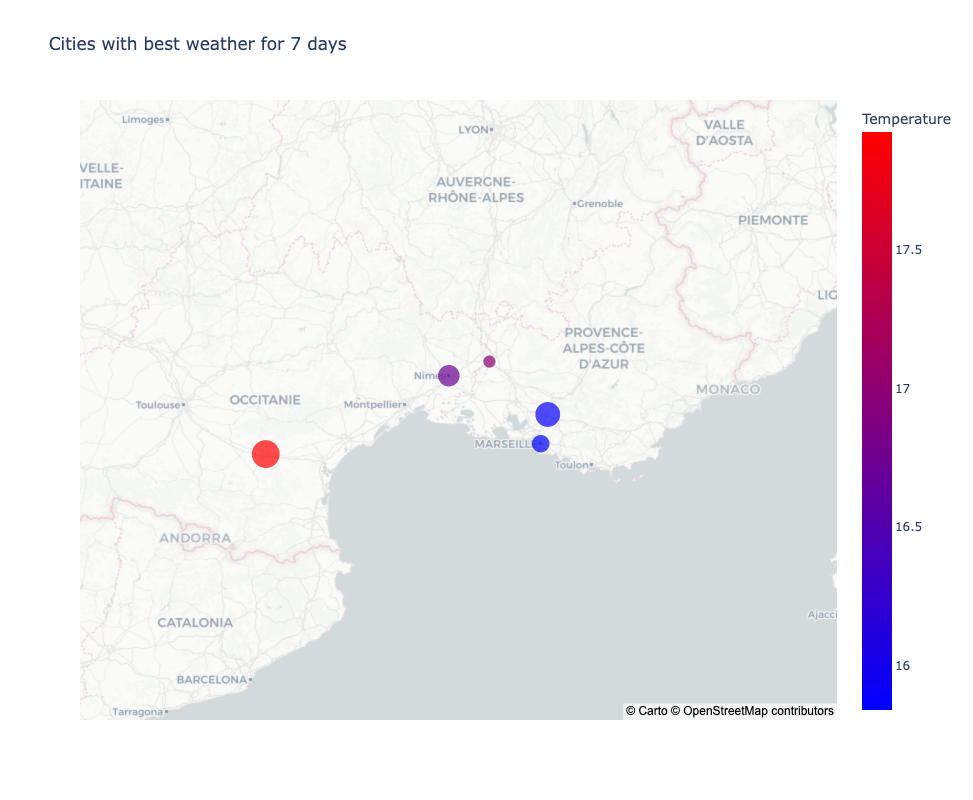

In [242]:
fig = px.scatter_mapbox(top5_weather, lat="latitude", lon="longitude", 
            hover_name = 'City',
            color = 'day_temperature', 
            color_continuous_scale = px.colors.sequential.Bluered, 
            size=[5,4,3,2,1],
            mapbox_style="carto-positron",
            width = 900, height = 800,
            zoom = 6,
            labels={"day_temperature":"Temperature"},
 
            title='Cities with best weather for 7 days')
fig.show()

## 12. Plotting 20 best hotels within top5 cities

In [129]:
# Getting the hotels we need based on weather selection
statement2 = text("""SELECT "City", hotel_name, hotel_lat, hotel_long, url, description, "Rating" 
                  FROM df_total 
                  WHERE "City" in ('Carcassonne', 'Aix en Provence', 'Nimes', 'Marseille', 'Avignon')
                  ORDER BY "Rating" DESC
                  LIMIT 20""")
top20_hotels = pd.read_sql(statement2, engine)

#Transforming coordinates type to float
top20_hotels[['hotel_lat','hotel_long']]=top20_hotels[['hotel_lat','hotel_long']].astype(float)
top20_hotels

2024-03-29 09:49:17,900 INFO sqlalchemy.engine.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s


2024-03-29 09:49:17 [sqlalchemy.engine.Engine] INFO: select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s


2024-03-29 09:49:17,904 INFO sqlalchemy.engine.Engine [cached since 8853s ago] {'name': 'SELECT "City", hotel_name, hotel_lat, hotel_long, url, description, "Rating" \n                  FROM df_total \n                  WHERE "City" in (\'Carcassonne\', \'Aix en Provence\', \'Nimes\', \'Marseille\', \'Avignon\')\n                  ORDER BY "Rating" DESC\n                  LIMIT 20'}


2024-03-29 09:49:17 [sqlalchemy.engine.Engine] INFO: [cached since 8853s ago] {'name': 'SELECT "City", hotel_name, hotel_lat, hotel_long, url, description, "Rating" \n                  FROM df_total \n                  WHERE "City" in (\'Carcassonne\', \'Aix en Provence\', \'Nimes\', \'Marseille\', \'Avignon\')\n                  ORDER BY "Rating" DESC\n                  LIMIT 20'}


2024-03-29 09:49:18,083 INFO sqlalchemy.engine.Engine SELECT "City", hotel_name, hotel_lat, hotel_long, url, description, "Rating" 
                  FROM df_total 
                  WHERE "City" in ('Carcassonne', 'Aix en Provence', 'Nimes', 'Marseille', 'Avignon')
                  ORDER BY "Rating" DESC
                  LIMIT 20


2024-03-29 09:49:18 [sqlalchemy.engine.Engine] INFO: SELECT "City", hotel_name, hotel_lat, hotel_long, url, description, "Rating" 
                  FROM df_total 
                  WHERE "City" in ('Carcassonne', 'Aix en Provence', 'Nimes', 'Marseille', 'Avignon')
                  ORDER BY "Rating" DESC
                  LIMIT 20


2024-03-29 09:49:18,085 INFO sqlalchemy.engine.Engine [cached since 251.4s ago] {}


2024-03-29 09:49:18 [sqlalchemy.engine.Engine] INFO: [cached since 251.4s ago] {}


,City,hotel_name,hotel_lat,hotel_long,url,description,Rating
0,Nimes,Mazet Pierre de Vers - Le Mas des Olivers Nîmes,43.858731,4.392550,https://www.booking.com/hotel/fr/mazet-pierre-...,Le Mazet Pierre de Vers - Le Mas des Olivers N...,"9,8"
1,Avignon,Bastide de Bellegarde,43.975040,4.822944,https://www.booking.com/hotel/fr/bastide-de-be...,"Situé à moins de 5,9 km du palais des Papes et...","9,8"
2,Aix en Provence,"Les Chambres Romantiques - JACUZZI Privatif, D...",43.591905,5.390908,https://www.booking.com/hotel/fr/chambres-roma...,"Situé à Aix-en-Provence, l'établissement Les C...","9,8"
3,Carcassonne,La Maison de La Tour Pinte,43.205804,2.360999,https://www.booking.com/hotel/fr/la-maison-de-...,"Offrant une vue sur le jardin, La Maison de La...","9,8"
4,Carcassonne,Le Loft de La Tour Pinte,43.207188,2.361495,https://www.booking.com/hotel/fr/le-loft-de-la...,"Situé à Carcassonne, à 50 km du château des Te...","9,7"
5,Nimes,Mas d'Escattes,43.870469,4.404910,https://www.booking.com/hotel/fr/mas-d-39-esca...,Doté d'une piscine extérieure et offrant une v...,"9,7"
6,Nimes,Guest House Encantada,43.853052,4.351386,https://www.booking.com/hotel/fr/encantadahome...,"Offrant une vue sur la piscine, le Guest House...","9,7"
7,Carcassonne,"Au point du jour - Gîtes Carcassonne, Lac de l...",43.178580,2.414622,https://www.booking.com/hotel/fr/au-point-du-j...,"Situé à Carcassonne, à 3,4 km du lac de la Cav...","9,7"
8,Carcassonne,Le Jardin de La Tour Pinte,43.207647,2.361746,https://www.booking.com/hotel/fr/le-jardin-de-...,"Situé à Carcassonne, à 50 km du château des Te...","9,7"
9,Carcassonne,LA COUR CARREE,43.210880,2.350076,https://www.booking.com/hotel/fr/la-cour-carre...,"Situé à Carcassonne, à 50 km du château des Te...","9,7"


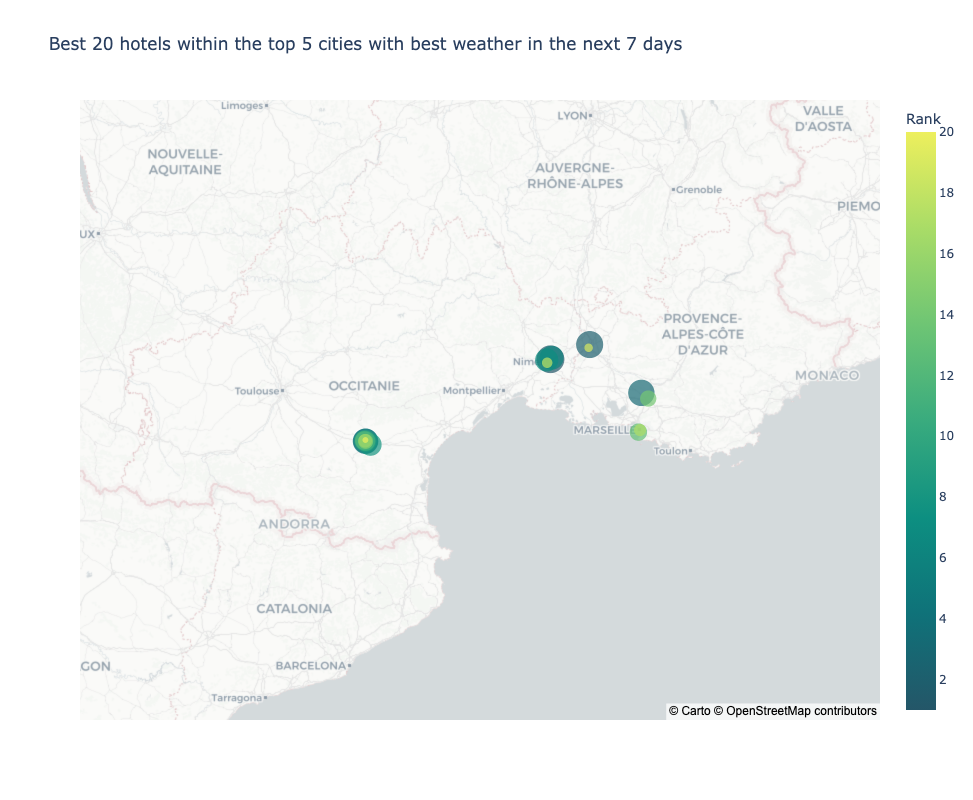

In [243]:
#Creating list from 1 to 20
numbers = list(range(1,21))
#Reverse the list 
reversed_numbers = reversed(numbers)

#Plot the map
fig = px.scatter_mapbox(top20_hotels, lat="hotel_lat", lon="hotel_long", 
            hover_name = 'hotel_name',
            color = top20_hotels.index+1, #+1 to get rank starting from 1 and not 0
            color_continuous_scale = px.colors.sequential.Aggrnyl, 
            size=list(reversed_numbers),
            mapbox_style="carto-positron",
            width = 900, height = 800,
            zoom = 6,
            labels={"color":"Rank"},
            hover_data={"hotel_lat":True, "hotel_long":True},
            title='Best 20 hotels within the top 5 cities with best weather in the next 7 days')
fig.show()